### This notebook looks at the impact of systematically deleting SC ...the INNER connectivity i.e., from ntwx A to itself, ntwx B to itself when ntwx X is isolated ...and then readding the ntwx that it is has the highest FC with.

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 4s, sys: 338 ms, total: 1min 5s
Wall time: 1min 16s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.4 s, sys: 198 ms, total: 1.6 s
Wall time: 1.6 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  original isolated ntwx

In [14]:
%%time

all_subs_og_whobpyt = []
all_subs_vis_lesion = []
all_subs_smt_lesion = []
all_subs_dan_lesion = []
all_subs_van_lesion = []
all_subs_lim_lesion = []
all_subs_fpn_lesion = []
all_subs_dmn_lesion = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    

    ss_smt_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_smt_lesion.append(ss_smt_lesion)

    ss_dan_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dan_lesion.append(ss_dan_lesion)
    

    ss_van_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_van_lesion.append(ss_van_lesion)

    
    ss_lim_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_lim_lesion.append(ss_lim_lesion)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
    
    del ss_og_whobpyt,ss_vis_lesion,ss_smt_lesion,ss_dan_lesion,ss_van_lesion,ss_lim_lesion,ss_fpn_lesion,ss_dmn_lesion

CPU times: user 1min 33s, sys: 2.03 s, total: 1min 35s
Wall time: 3min 9s


###  re_add highest FC ntwx

In [15]:
re_add_lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_and_ReAdd_WhoBPyT_200_subs'

In [17]:
%%time

# re_add_all_subs_og_whobpyt = []
re_add_all_subs_vis_lesion = []
re_add_all_subs_smt_lesion = []
re_add_all_subs_dan_lesion = []
re_add_all_subs_van_lesion = []
re_add_all_subs_lim_lesion = []
re_add_all_subs_fpn_lesion = []
re_add_all_subs_dmn_lesion = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
#     ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
#     re_add_all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_vis_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_vis_lesion.append(ss_vis_lesion)
    

    ss_smt_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_smt_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_smt_lesion.append(ss_smt_lesion)

    ss_dan_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_dan_lesion_re_add_vis_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_dan_lesion.append(ss_dan_lesion)
    

    ss_van_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_van_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_van_lesion.append(ss_van_lesion)

    
    ss_lim_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_lim_lesion_re_add_dmn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_lim_lesion.append(ss_lim_lesion)

    
    ss_fpn_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_fpn_lesion_re_add_dmn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_fpn_lesion.append(ss_fpn_lesion)

    
    ss_dmn_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_dmn_lesion_re_add_fpn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_dmn_lesion.append(ss_dmn_lesion)
    
    del ss_vis_lesion,ss_smt_lesion,ss_dan_lesion,ss_van_lesion,ss_lim_lesion,ss_fpn_lesion,ss_dmn_lesion

CPU times: user 1min 17s, sys: 1.9 s, total: 1min 19s
Wall time: 2min 6s


In [15]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is INNER connectivity ... i.e., the average ntwx conn to itself (so Vis to Vis, DMN to DMN, etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

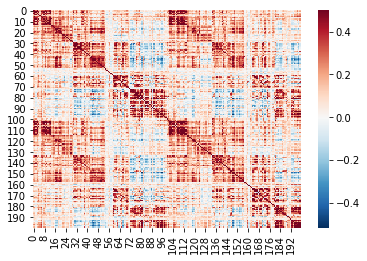

In [18]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

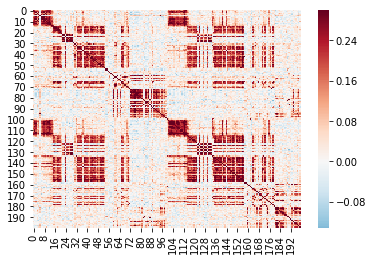

In [19]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [20]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [21]:
# corrs_list

In [22]:
# ntwx_only_lh[(ntwx_only_lh>0.1)] # & (ntwx_only_rh<0.9)

In [23]:
def ntwx_only_fc(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_rh = fc[sub][c:d, c:d]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [24]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [25]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### original whobpyt

In [26]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs = []
org_whobpyt_smt_mean_fc_all_subs = []
org_whobpyt_dan_mean_fc_all_subs = []
org_whobpyt_van_mean_fc_all_subs = []
org_whobpyt_lim_mean_fc_all_subs = []
org_whobpyt_fpn_mean_fc_all_subs = []
org_whobpyt_dmn_mean_fc_all_subs = []

for i in range(200):
    
    temp_vis = ntwx_only_fc(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs.append(temp_vis)
    
    temp_smt = ntwx_only_fc(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_smt_mean_fc_all_subs.append(temp_smt)

    temp_dan = ntwx_only_fc(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dan_mean_fc_all_subs.append(temp_dan)

    temp_van = ntwx_only_fc(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_van_mean_fc_all_subs.append(temp_van)

    temp_lim = ntwx_only_fc(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_lim_mean_fc_all_subs.append(temp_lim)

    temp_fpn = ntwx_only_fc(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs.append(temp_fpn)

    temp_dmn = ntwx_only_fc(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_mean = np.mean(org_whobpyt_vis_mean_fc_all_subs)
org_whobpyt_smt_mean_fc_all_subs_mean = np.mean(org_whobpyt_smt_mean_fc_all_subs)
org_whobpyt_dan_mean_fc_all_subs_mean = np.mean(org_whobpyt_dan_mean_fc_all_subs)
org_whobpyt_van_mean_fc_all_subs_mean = np.mean(org_whobpyt_van_mean_fc_all_subs)
org_whobpyt_lim_mean_fc_all_subs_mean = np.mean(org_whobpyt_lim_mean_fc_all_subs)
org_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(org_whobpyt_fpn_mean_fc_all_subs)
org_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dmn_mean_fc_all_subs)


org_whobpyt_means = [org_whobpyt_vis_mean_fc_all_subs_mean,
org_whobpyt_smt_mean_fc_all_subs_mean,
org_whobpyt_dan_mean_fc_all_subs_mean,
org_whobpyt_van_mean_fc_all_subs_mean,
org_whobpyt_lim_mean_fc_all_subs_mean,
org_whobpyt_fpn_mean_fc_all_subs_mean,
org_whobpyt_dmn_mean_fc_all_subs_mean]

CPU times: user 152 ms, sys: 13.1 ms, total: 165 ms
Wall time: 161 ms


In [27]:
org_whobpyt_means

[0.2381039300052709,
 0.18159082694176334,
 0.21459717983754742,
 0.19481845006681628,
 0.11863332314529478,
 0.12874539763860968,
 0.1304547462593384]

In [28]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

In [29]:
def func_for_inner_ntwx_connectivity(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_smt_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dan_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_van_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_lim_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_smt = ntwx_only_fc(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_smt_mean_fc_all_subs.append(ntwx_lesion_temp_smt)

        ntwx_lesion_temp_dan = ntwx_only_fc(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dan_mean_fc_all_subs.append(ntwx_lesion_temp_dan)

        ntwx_lesion_temp_van = ntwx_only_fc(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_van_mean_fc_all_subs.append(ntwx_lesion_temp_van)

        ntwx_lesion_temp_lim = ntwx_only_fc(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_lim_mean_fc_all_subs.append(ntwx_lesion_temp_lim)

        ntwx_lesion_temp_fpn = ntwx_only_fc(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_vis_mean_fc_all_subs)
    ntwx_lesion_whobpyt_smt_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_smt_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dan_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dan_mean_fc_all_subs)
    ntwx_lesion_whobpyt_van_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_van_mean_fc_all_subs)
    ntwx_lesion_whobpyt_lim_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_lim_mean_fc_all_subs)
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs)


    ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_smt_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dan_mean_fc_all_subs,ntwx_lesion_whobpyt_van_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_lim_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]
    
    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_smt_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dan_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_van_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_lim_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [30]:
org2_whobpyt_means, org2_all_subs = func_for_inner_ntwx_connectivity(all_subs_og_whobpyt)

In [32]:
org_whobpyt_df = pd.DataFrame(org2_all_subs,index=ntwx_labels)

org_whobpyt_df = org_whobpyt_df.T

# org_whobpyt_df

#### lesion

In [34]:
%%time
vis_lesion_whobpyt_means, vis_all_subs = func_for_inner_ntwx_connectivity(all_subs_vis_lesion)
smt_lesion_whobpyt_means, smt_all_subs = func_for_inner_ntwx_connectivity(all_subs_smt_lesion)
dan_lesion_whobpyt_means, dan_all_subs = func_for_inner_ntwx_connectivity(all_subs_dan_lesion)
van_lesion_whobpyt_means, van_all_subs = func_for_inner_ntwx_connectivity(all_subs_van_lesion)
lim_lesion_whobpyt_means, lim_all_subs = func_for_inner_ntwx_connectivity(all_subs_lim_lesion)
fpn_lesion_whobpyt_means, fpn_all_subs = func_for_inner_ntwx_connectivity(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means, dmn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dmn_lesion)

CPU times: user 861 ms, sys: 85 ms, total: 946 ms
Wall time: 935 ms


In [36]:
ntwx_lesion_whobpyt_means = [vis_lesion_whobpyt_means,
smt_lesion_whobpyt_means,
dan_lesion_whobpyt_means,
van_lesion_whobpyt_means,
lim_lesion_whobpyt_means,
fpn_lesion_whobpyt_means,
dmn_lesion_whobpyt_means]

#### lesion + re_add

In [41]:
%%time

vis_re_add_lesion_whobpyt_means, vis_re_add_all_subs = func_for_inner_ntwx_connectivity(re_add_all_subs_vis_lesion)
smt_re_add_lesion_whobpyt_means, smt_re_add_all_subs = func_for_inner_ntwx_connectivity(re_add_all_subs_smt_lesion)
dan_re_add_lesion_whobpyt_means, dan_re_add_all_subs = func_for_inner_ntwx_connectivity(re_add_all_subs_dan_lesion)
van_re_add_lesion_whobpyt_means, van_re_add_all_subs = func_for_inner_ntwx_connectivity(re_add_all_subs_van_lesion)
lim_re_add_lesion_whobpyt_means, lim_re_add_all_subs = func_for_inner_ntwx_connectivity(re_add_all_subs_lim_lesion)
fpn_re_add_lesion_whobpyt_means, fpn_re_add_all_subs = func_for_inner_ntwx_connectivity(re_add_all_subs_fpn_lesion)
dmn_re_add_lesion_whobpyt_means, dmn_re_add_all_subs = func_for_inner_ntwx_connectivity(re_add_all_subs_dmn_lesion)

CPU times: user 904 ms, sys: 152 ms, total: 1.06 s
Wall time: 1.05 s


In [42]:
ntwx_lesion_re_add_whobpyt_means = [vis_re_add_lesion_whobpyt_means,
smt_re_add_lesion_whobpyt_means,
dan_re_add_lesion_whobpyt_means,
van_re_add_lesion_whobpyt_means,
lim_re_add_lesion_whobpyt_means,
fpn_re_add_lesion_whobpyt_means,
dmn_re_add_lesion_whobpyt_means]

In [38]:
org_whobpyt_means

[0.2381039300052709,
 0.18159082694176334,
 0.21459717983754742,
 0.19481845006681628,
 0.11863332314529478,
 0.12874539763860968,
 0.1304547462593384]

### Bar Plots

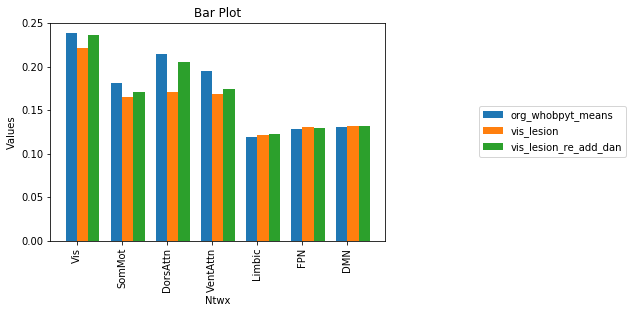

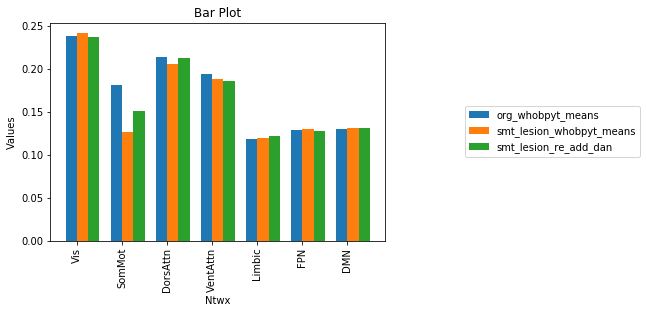

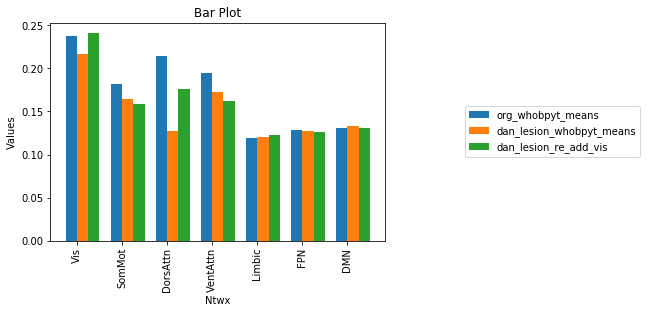

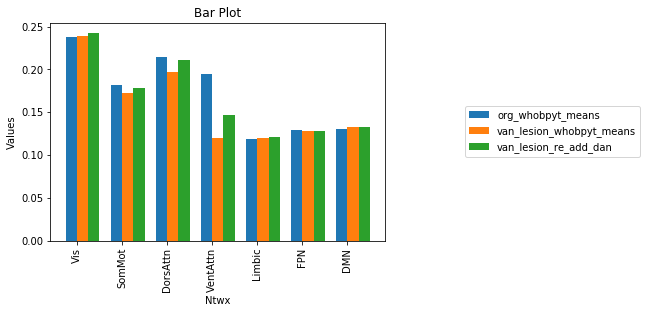

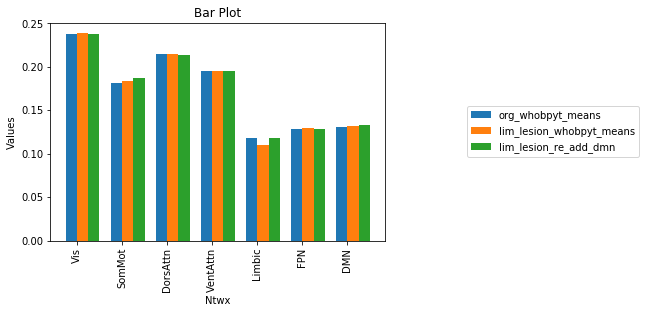

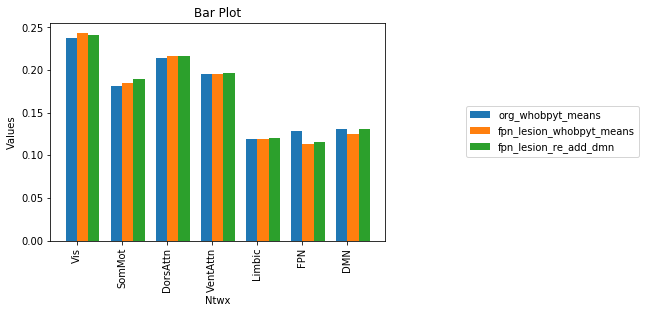

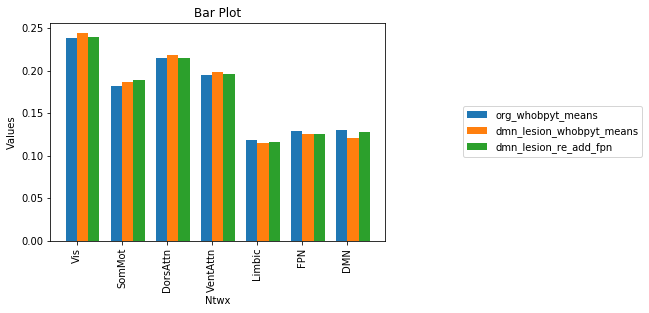

In [50]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.25  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], vis_lesion_whobpyt_means, width, label='vis_lesion')
rects3 = ax.bar([i + 2*width for i in x], vis_re_add_lesion_whobpyt_means, width, label='vis_lesion_re_add_dan')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### smt

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
#  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], smt_lesion_whobpyt_means, width, label='smt_lesion_whobpyt_means')
rects3 = ax.bar([i + 2*width for i in x], smt_re_add_lesion_whobpyt_means, width, label='smt_lesion_re_add_dan')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### dan

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
#  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dan_lesion_whobpyt_means, width, label='dan_lesion_whobpyt_means')
rects3 = ax.bar([i + 2*width for i in x], dan_re_add_lesion_whobpyt_means, width, label='dan_lesion_re_add_vis')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### van

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
#  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], van_lesion_whobpyt_means, width, label='van_lesion_whobpyt_means')
rects3 = ax.bar([i + 2*width for i in x], van_re_add_lesion_whobpyt_means, width, label='van_lesion_re_add_dan')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### lim

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
#  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], lim_lesion_whobpyt_means, width, label='lim_lesion_whobpyt_means')
rects3 = ax.bar([i + 2*width for i in x], lim_re_add_lesion_whobpyt_means, width, label='lim_lesion_re_add_dmn')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### FPN

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
#  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], fpn_lesion_whobpyt_means, width, label='fpn_lesion_whobpyt_means')
rects3 = ax.bar([i + 2*width for i in x], fpn_re_add_lesion_whobpyt_means, width, label='fpn_lesion_re_add_dmn')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### DMN lesion

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
#  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dmn_lesion_whobpyt_means, width, label='dmn_lesion_whobpyt_means')
rects3 = ax.bar([i + 2*width for i in x], dmn_re_add_lesion_whobpyt_means, width, label='dmn_lesion_re_add_fpn')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

## -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

### Stats

#### VIS

In [62]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(vis_all_subs[i], vis_re_add_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -1.745713204015479
P-Value: 0.08163244138464176 

-------------------
Network =  SomMot
T-Statistic: -0.8208209036617842
P-Value: 0.412239648159461 

-------------------
Network =  DorsAttn
T-Statistic: -4.533177249375945
P-Value: 7.696926687874498e-06 

-------------------
Network =  VentAttn
T-Statistic: -0.7787270963053385
P-Value: 0.43660322750980496 

-------------------
Network =  Limbic
T-Statistic: -0.4320698671834369
P-Value: 0.6659246196965701 

-------------------
Network =  FPN
T-Statistic: 0.44510152112379925
P-Value: 0.6564883660758483 

-------------------
Network =  DMN
T-Statistic: -0.19735525843553958
P-Value: 0.8436502887741146 

-------------------


#### SMT

In [63]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(smt_all_subs[i], smt_re_add_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.7853313564162461
P-Value: 0.43272655631716506 

-------------------
Network =  SomMot
T-Statistic: -3.0010998063080083
P-Value: 0.0028594587850544993 

-------------------
Network =  DorsAttn
T-Statistic: -1.006260085562013
P-Value: 0.31490184997291376 

-------------------
Network =  VentAttn
T-Statistic: 0.3092495271982631
P-Value: 0.7572935513110087 

-------------------
Network =  Limbic
T-Statistic: -1.0434408512994713
P-Value: 0.2973775233950506 

-------------------
Network =  FPN
T-Statistic: 0.5171536554223063
P-Value: 0.6053361767930128 

-------------------
Network =  DMN
T-Statistic: -0.11603346956878563
P-Value: 0.9076845390886685 

-------------------


#### DAN

In [65]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(dan_all_subs[i], dan_re_add_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -3.633932172141704
P-Value: 0.00031570316641070767 

-------------------
Network =  SomMot
T-Statistic: 0.8135268059149001
P-Value: 0.4164024996666432 

-------------------
Network =  DorsAttn
T-Statistic: -5.002140153618296
P-Value: 8.522173136127053e-07 

-------------------
Network =  VentAttn
T-Statistic: 1.3671551065224992
P-Value: 0.1723483369853367 

-------------------
Network =  Limbic
T-Statistic: -0.5880262763313128
P-Value: 0.5568481574240381 

-------------------
Network =  FPN
T-Statistic: 0.16217356602546104
P-Value: 0.8712514757163459 

-------------------
Network =  DMN
T-Statistic: 0.30726592121583446
P-Value: 0.7588016830829033 

-------------------


#### VAN

In [64]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(van_all_subs[i], van_re_add_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -0.5772402685115541
P-Value: 0.5641035306764404 

-------------------
Network =  SomMot
T-Statistic: -0.8703594788593599
P-Value: 0.38462861806584026 

-------------------
Network =  DorsAttn
T-Statistic: -2.2495441783223753
P-Value: 0.025023756245785157 

-------------------
Network =  VentAttn
T-Statistic: -3.1954203525953124
P-Value: 0.0015076030327732502 

-------------------
Network =  Limbic
T-Statistic: -0.4284435858418908
P-Value: 0.6685599706028355 

-------------------
Network =  FPN
T-Statistic: 0.08039566585832085
P-Value: 0.9359629836907268 

-------------------
Network =  DMN
T-Statistic: -0.06613627401023535
P-Value: 0.9473025397583853 

-------------------


#### LIM

In [66]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(lim_all_subs[i], lim_re_add_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.24004491629357635
P-Value: 0.8104190208820072 

-------------------
Network =  SomMot
T-Statistic: -0.5650623751606401
P-Value: 0.5723497009280265 

-------------------
Network =  DorsAttn
T-Statistic: 0.2434155654451421
P-Value: 0.8078088977441628 

-------------------
Network =  VentAttn
T-Statistic: 0.014279244424619012
P-Value: 0.9886143534941049 

-------------------
Network =  Limbic
T-Statistic: -2.8956031684910317
P-Value: 0.0039929399833283415 

-------------------
Network =  FPN
T-Statistic: 0.09964391772410151
P-Value: 0.9206771960859464 

-------------------
Network =  DMN
T-Statistic: -0.10138383996381678
P-Value: 0.9192968190771332 

-------------------


#### FPN

In [67]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(fpn_all_subs[i], fpn_re_add_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.48415903886296857
P-Value: 0.628539307390032 

-------------------
Network =  SomMot
T-Statistic: -0.8979700969320927
P-Value: 0.369744381925566 

-------------------
Network =  DorsAttn
T-Statistic: -0.18600828252705634
P-Value: 0.852533031178183 

-------------------
Network =  VentAttn
T-Statistic: -0.2085595649221622
P-Value: 0.8348987708855751 

-------------------
Network =  Limbic
T-Statistic: -0.3766799271361619
P-Value: 0.7066122194886351 

-------------------
Network =  FPN
T-Statistic: -0.49955016082035253
P-Value: 0.6176678983473192 

-------------------
Network =  DMN
T-Statistic: -1.2088637835072582
P-Value: 0.22743285363890514 

-------------------


#### DMN

In [68]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(dmn_all_subs[i], dmn_re_add_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.8394400103913435
P-Value: 0.40172636991499056 

-------------------
Network =  SomMot
T-Statistic: -0.4580744066314382
P-Value: 0.6471489800620709 

-------------------
Network =  DorsAttn
T-Statistic: 0.5300812538490549
P-Value: 0.5963511890969057 

-------------------
Network =  VentAttn
T-Statistic: 0.5075603450952784
P-Value: 0.6120428460139821 

-------------------
Network =  Limbic
T-Statistic: -0.8154013847664603
P-Value: 0.41533027884296303 

-------------------
Network =  FPN
T-Statistic: -0.04704173649851261
P-Value: 0.9625035585665763 

-------------------
Network =  DMN
T-Statistic: -1.2885846527182923
P-Value: 0.19829106073935826 

-------------------
